In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
SHUFFLE = 1000

In [5]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "potato village",
    shuffle = True,  # Shuffles the files
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(df)

68

In [8]:
for image_batch, label_batch in df.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 0 1 0 1 2 0 0 1 2 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 0]


In [9]:
print(image_batch[0])

tf.Tensor(
[[[126. 118. 139.]
  [125. 118. 136.]
  [107. 103. 117.]
  ...
  [163. 165. 178.]
  [163. 165. 178.]
  [169. 171. 184.]]

 [[102.  94. 115.]
  [125. 118. 136.]
  [132. 128. 142.]
  ...
  [162. 164. 177.]
  [164. 166. 179.]
  [170. 172. 185.]]

 [[ 96.  89. 107.]
  [116. 109. 125.]
  [124. 120. 134.]
  ...
  [165. 167. 180.]
  [168. 170. 183.]
  [172. 174. 187.]]

 ...

 [[107. 103. 118.]
  [118. 114. 129.]
  [124. 120. 135.]
  ...
  [189. 191. 204.]
  [134. 136. 149.]
  [166. 168. 181.]]

 [[110. 106. 121.]
  [123. 119. 134.]
  [129. 125. 140.]
  ...
  [183. 185. 198.]
  [148. 150. 163.]
  [149. 151. 164.]]

 [[111. 107. 122.]
  [123. 119. 134.]
  [127. 123. 138.]
  ...
  [170. 172. 185.]
  [157. 159. 172.]
  [180. 182. 195.]]], shape=(256, 256, 3), dtype=float32)


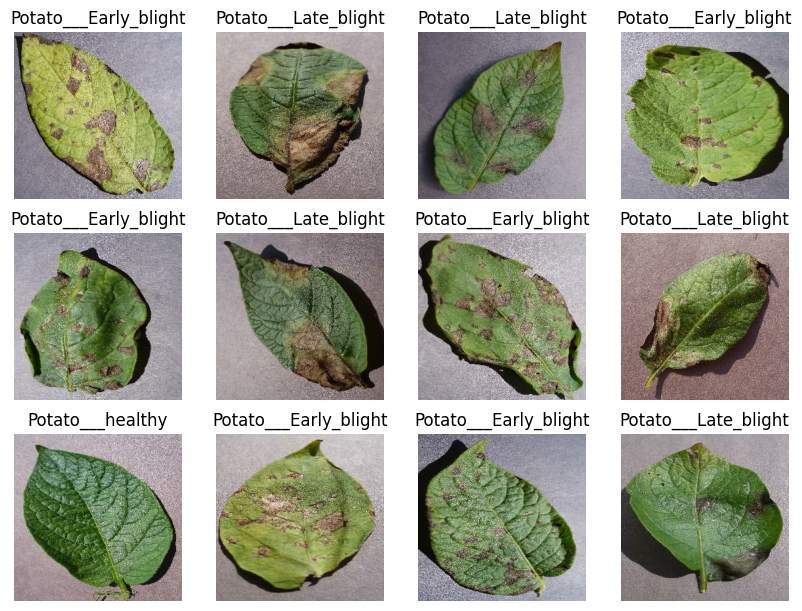

In [10]:
plt.figure(figsize=(10,10))
for i in range(12):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image_batch[i].numpy().astype('uint8'))
  plt.axis("off")
  plt.title(class_names[label_batch[i]])


Now we will split dataset as follows:
80% ==> Training
20% ==> 10% validation, 10% test

In [11]:
train_size = 0.8
len(df)*train_size

54.400000000000006

In [12]:
train_df = df.take(54)
len(train_df)

54

In [13]:
test_df = df.skip(54)
len(test_df)  # this is not actual test dataset

14

In [14]:
val_size = 0.1
len(df)*val_size

6.800000000000001

In [15]:
val_df = test_df.take(6)
len(val_df) 

6

In [16]:
test_df = test_df.skip(6)
len(test_df)  # this is actual test dataset

8

We are creating a function which will split our dataset into train, test or validation data partitions.

In [17]:
def get_dataset_partitions_tf(df, train_split = 0.8, val_split=0.1, test_split= 0.1, shuffle_size = 10000 ):
    shuffle = SHUFFLE
    df_size = len(df)
    if shuffle:
       df =  df.shuffle(shuffle_size,seed=12)
        
    train_size = int(train_split * df_size)
    val_size = int(val_split * df_size)

    train_df = df.take(train_size)
    val_df = df.skip(train_size).take(val_size)
    test_df = df.skip(train_size).skip(val_size)
    return train_df, val_df, test_df

In [18]:
train_df, val_df, test_df = get_dataset_partitions_tf(df)

In [19]:
len(train_df)

54

In [20]:
len(test_df)

8

In [21]:
len(val_df)

6

Making the dataset more responsive by using the cach memory functions and prefetch technique to save more and more time

In [22]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
# resize_and_rescale = tf.keras.Sequential([
#   layers.experimental.preprocessing.Resizing(IMAGE_SIZE , IMAGE_SIZE),
#   layers.experimental.preprocessing.Rescalling(1.0/255)
# ])
# .experimental is not working here

In [24]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])


In [25]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2)
])

### Training Model:

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64 ,activation='relu'),
    layers.Dense(n_classes ,activation='softmax'),
])
model.build(input_shape=input_shape)

c:\Users\akr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile (
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [29]:
history = model.fit(
    train_df,
    epochs= EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_df
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.4649 - loss: 0.9551 - val_accuracy: 0.6094 - val_loss: 0.7708
Epoch 2/50
36/54 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6910 - loss: 0.7121

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(test_df)

8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 388ms/step - accuracy: 0.9190 - loss: 0.2747


In [ ]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

NameError: name 'history' is not defined

Text(0.5, 1.0, 'Training and Validation Accuracy')

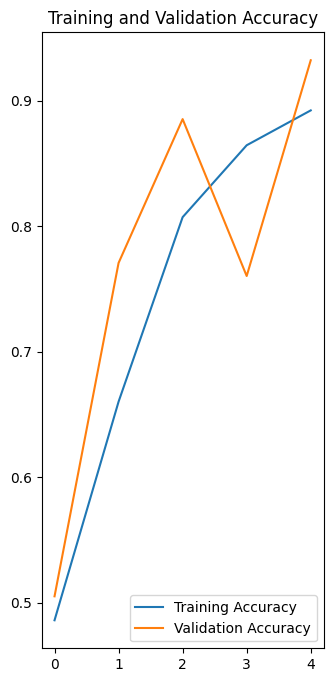

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation loss')

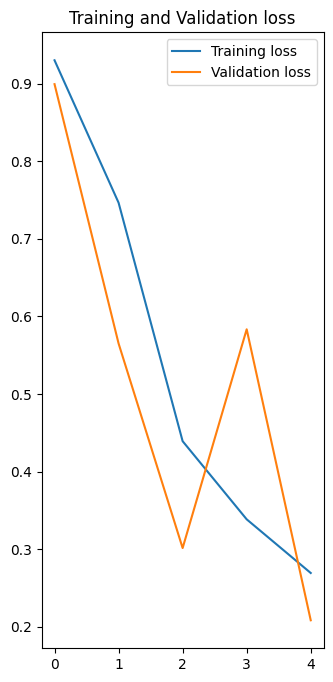

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss , label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')

## Making Predictions :

first image to predict
first image actual label:  Potato___Late_blight


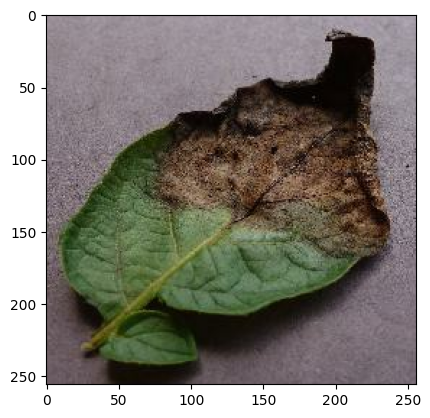

In [ ]:
for image_batch, label_batch in test_df.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print('first image actual label: ', class_names[first_label])

In [ ]:
import numpy as np
batch_prediction = model.predict(image_batch)
print('prediction_label :', class_names[np.argmax(batch_prediction[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
prediction_label : Potato___Late_blight


Making function which takes input and provide answers

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy)
    img_array = tf.expand_dims(img_array, 0) 

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.argmax(predictions[0])), 2)
    return predicted_class, confidence

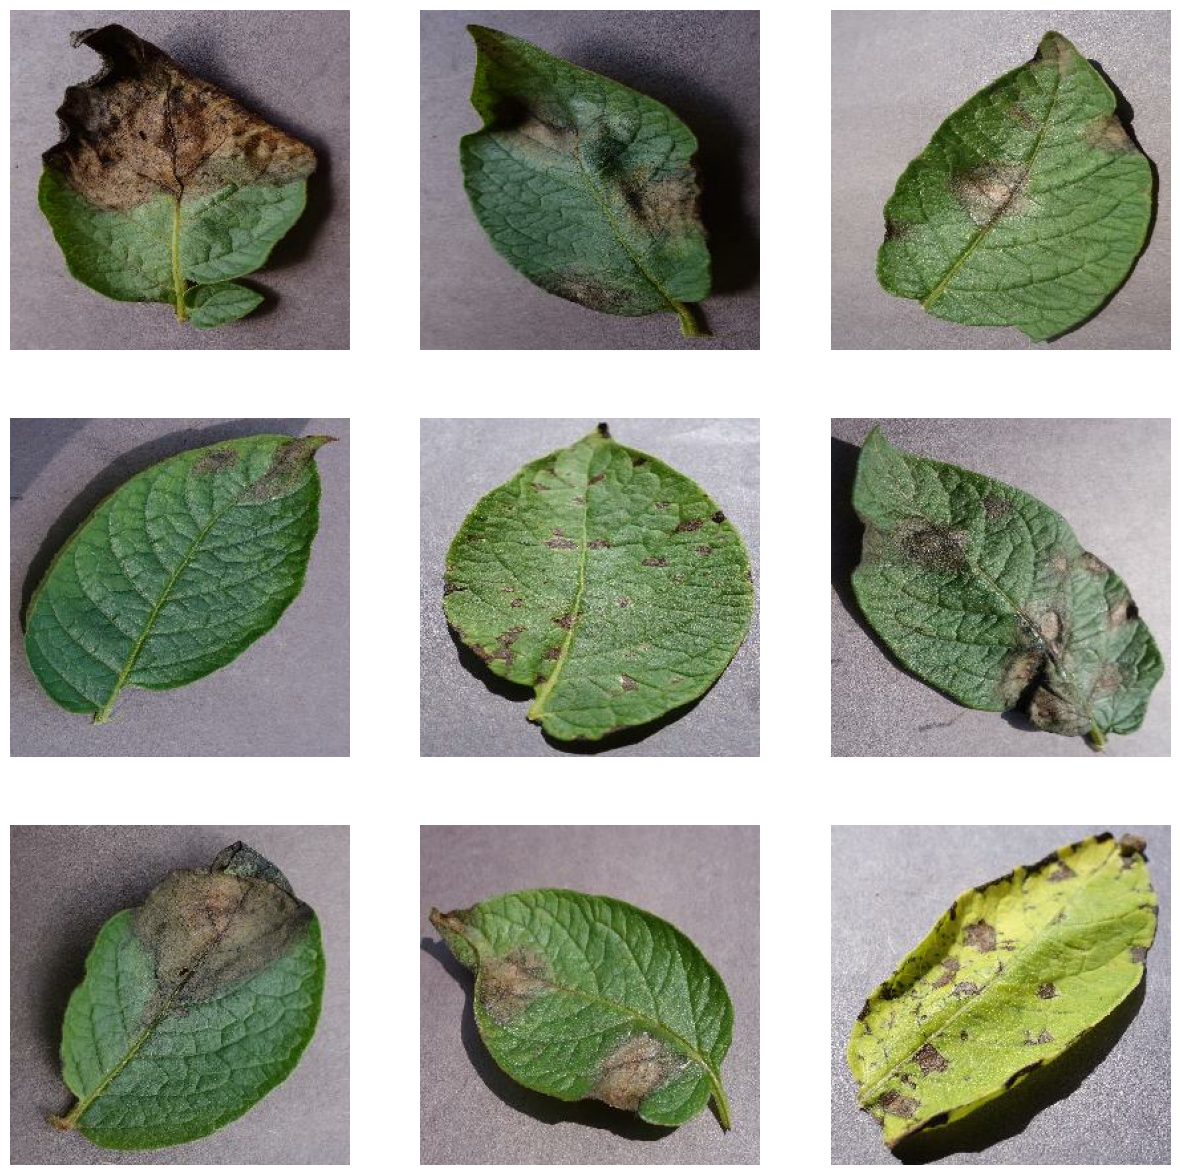

In [ ]:
plt.figure(figsize=(15, 15))
for images,labels in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i +1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        actual_class = class_names[labels[i]]
        
        plt.axis('off')

In [ ]:
model_name = "Potato_Blight_Prediction_Model"  
model.save(f"../Deep_Learning_Models/{model_name}.keras")